In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
import scipy 

# Частина №1

In [2]:
filename = 'data_p1.txt'
with open(filename, 'r') as file:
    lines = file.readlines()
hi = []
ni = []
for line in lines[:10]:
    start, end = map(int, line.strip().split(','))
    hi.append([start, end])
ni = list(map(int, lines[-1].strip().split(',')))

hi = [[4, 4.5], [4.5, 5], [5, 5.5], [5.5, 6], [6, 6.5], [6.5, 7], [7, 7.5], [7.5, 8], [8, 8.5], [8.5, 9]]
ni = [1, 3, 18,66, 106, 116, 64, 23, 2,1]
table = pd.DataFrame({'hi': hi, 'ni': ni })
display(table.T)        

,0,1,2,3,4,5,6,7,8,9
hi,"[4, 4.5]","[4.5, 5]","[5, 5.5]","[5.5, 6]","[6, 6.5]","[6.5, 7]","[7, 7.5]","[7.5, 8]","[8, 8.5]","[8.5, 9]"
ni,1,3,18,66,106,116,64,23,2,1


In [3]:
def mrg(ttable):
    tni, thi, tpi = [], [], []
    while not ttable.empty:
        i = 0  
        if ttable['ni'].iloc[i] < 5 or ttable['pi'].iloc[i]*ttable['ni'].sum()<10 :
            if i == len(ttable) - 1:
                tni.append(ttable['ni'].iloc[i])
                thi.append(ttable['hi'].iloc[i])
                tpi.append(ttable['pi'].iloc[i])
            else:
                tni.append(ttable['ni'].iloc[i] + ttable['ni'].iloc[i + 1])
                thi.append([ttable['hi'].iloc[i][0], ttable['hi'].iloc[i + 1][1]])
                tpi.append(ttable['pi'].iloc[i] + ttable['pi'].iloc[i + 1])
                ttable = ttable.drop(ttable.index[i + 1])  
        else:
            if ttable['ni'].iloc[i+1]<5:
                tni.append(ttable['ni'].iloc[i] + ttable['ni'].iloc[i + 1])
                thi.append([ttable['hi'].iloc[i][0], ttable['hi'].iloc[i + 1][1]])
                tpi.append(ttable['pi'].iloc[i] + ttable['pi'].iloc[i + 1])
                ttable = ttable.drop(ttable.index[i + 1])  
            else: 
                tni.append(ttable['ni'].iloc[i])
                thi.append(ttable['hi'].iloc[i])
                tpi.append(ttable['pi'].iloc[i])
        ttable = ttable.drop(ttable.index[i]) 
    res = pd.DataFrame({'hi': thi, 'ni': tni, 'pi':tpi})
    return res

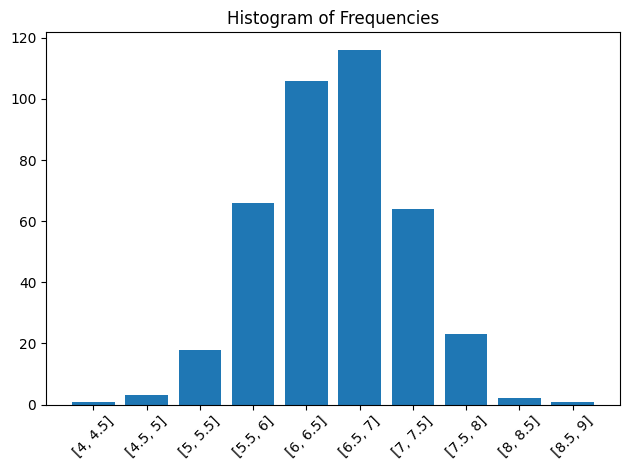

In [4]:
counts = table['ni']
plt.bar(range(len(table)), counts, tick_label=[f'{hi}' for hi in table['hi']])
plt.title('Histogram of Frequencies')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## Гіпотеза: Розподіл є нормальним

### Середньовибіркове

In [5]:
def sample_average(df):
    df=df.copy()
    df['x-']= list((df['hi'][i][1]+df['hi'][i][0])/2 for i in range(len(df)))
    df['x-']=df['x-']*df['ni']
    x = df['x-'].sum()/df['ni'].sum()
    return x

### Девіація

In [6]:
def deviation(df):
    df['xi-x-'] = (df['hi'].apply(lambda x: (x[1] + x[0]) / 2)) - sample_average(df)
    df['(xi-x-)^2'] = df['ni'] * (df['xi-x-'] ** 2)
    dev = df['(xi-x-)^2'].sum()
    return dev

### Стандарт

In [7]:
def standard(df):
    return round((deviation(df)/(df['ni'].sum()-1))**0.5, 3)    

## Визначення параметрів розподілу

In [8]:
choice=input("Якщо хочите ввести параметри розподілу введіть 1, якщо ні - 0") 
minis=0
if choice=="1":
    x = input("Введіть мат. сподівання: ")
    s = input("Введіть квадр. відхилення: ")
elif choice =="0":
    x = sample_average(table)
    s = standard(table)
    minus=2
print(x, s)

Якщо хочите ввести параметри розподілу введіть 1, якщо ні - 0 0


6.51375 0.665


### Обчислення функції Лапласа

In [9]:
def laplace_cdf_integral(t):
    integrand = lambda x: np.exp(-x**2 / 2)
    integral, _ = quad(integrand, 0, t)
    return (1 / np.sqrt(2 * np.pi)) * integral

### Обчислення емпіричного значення критерію Пірсона

In [10]:
def Pirsons_criterion(df):
    X=0
    n=df['ni'].sum()
    for i in range(len(df)):
        X+=((df['ni'][i]-n*df['pi'][i])**2)/(n*df['pi'][i])
    return X

In [17]:
list_ =[]
for i in table['hi']:
    xx = (i[1]-x)/s
    p = laplace_cdf_integral(xx)
    list_.append(p)
    
p=[]
for i in range(len(list_)):
    if i==0: p.append(0.5+list_[i])
    elif i==len(list_)-1: p.append(1-sum(p))
    else: p.append(list_[i] - list_[i-1])
table['pi']=p
mrg(mrg(table)).T

,0,1,2,3,4,5
hi,"[4, 5.5]","[5.5, 6]","[6, 6.5]","[6.5, 7]","[7, 7.5]","[7.5, 9]"
ni,22,66,106,116,64,26
pi,0.0637,0.156193,0.271859,0.275921,0.163301,0.069026


In [12]:
X_empirical = Pirsons_criterion(mrg(mrg(table)))
X_empirical

1.1511665912886841

### Обчислення критичного значення критерію Пірсона

In [13]:
level_of_significance = float(input("Введіть рівень значущості: "))

Введіть рівень значущості:  0.05


In [14]:
X_critical = scipy.stats.chi2.isf(level_of_significance, mrg(mrg(table)).shape[0]-1-minus) # alpha, d.f.
X_critical

7.814727903251178

# Висновок

In [15]:
if X_empirical<X_critical: print("Гіпотеза приймається")
elif X_empirical>X_critical: print("Гіпотеза НЕ приймається")

Гіпотеза приймається


# Частина №2

In [56]:
filename = 'data_p2.txt'
with open(filename, 'r') as file:
    lines = file.readlines()
hi = []
ni = []
for line in lines[:10]:
    start, end = map(float, line.strip().split(','))
    hi.append([start, end])

ni = list(map(int, lines[-1].strip().split(',')))
#hi = [[2, 4], [4, 6], [6, 8], [8, 10], [10, 12]]
#ni = [24, 16, 17, 22, 21]
data = {'hi': hi, 'ni': ni}
table = pd.DataFrame(data)
table.T

,0,1,2,3,4,5,6,7,8,9
hi,"[0.0, 1.5]","[1.5, 3.0]","[3.0, 4.5]","[4.5, 6.0]","[6.0, 7.5]","[7.5, 9.0]","[9.0, 10.5]","[10.5, 12.0]","[12.0, 13.5]","[13.5, 15.0]"
ni,142,141,138,136,137,142,143,154,144,135


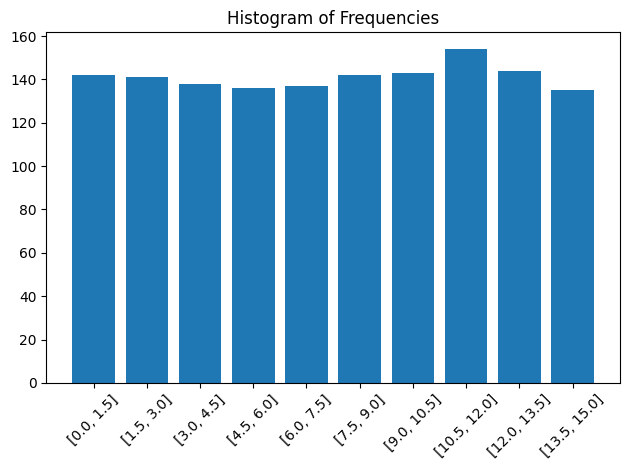

In [57]:
counts = table['ni']

plt.bar(range(len(table)), counts, tick_label=[f'{hi}' for hi in table['hi']])
plt.title('Histogram of Frequencies')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Гіпотеза: Розподіл є рівномірним

## Визначення параметрів розподілу

In [58]:
choice=input("Якщо хочите ввести параметри розподілу введіть 1, якщо ні - 0")  
if choice=="1":
    minus=0
    a = input("Введіть мат. сподівання: ")
    b = input("Введіть квадр. відхилення: ")
elif choice =="0":
    minus=2
    a=sample_average(table)-((3**(1/2))*standard(table))
    b=sample_average(table)+3**(1/2)*standard(table)
print(a, b)

Якщо хочите ввести параметри розподілу введіть 1, якщо ні - 0 0


0.07751560769360477 14.990473060861635


In [72]:
pi=[]
for i in range(len(table['hi'])):
    if i==0 : pi.append(round(1/(b-a)*(table['hi'][i][1]-a), 3))
    elif i==len(table['hi'])-1 :  
        sm = sum(pi)
        pi.append(round(1 - sm, 3))
    else: pi.append(round(1/(b-a)*(table['hi'][i][1]-table['hi'][i-1][1]),3))
table['pi']=pi
table[['hi', 'ni', 'pi']].T

,0,1,2,3,4,5,6,7,8,9
hi,"[0.0, 1.5]","[1.5, 3.0]","[3.0, 4.5]","[4.5, 6.0]","[6.0, 7.5]","[7.5, 9.0]","[9.0, 10.5]","[10.5, 12.0]","[12.0, 13.5]","[13.5, 15.0]"
ni,142,141,138,136,137,142,143,154,144,135
pi,0.095,0.101,0.101,0.101,0.101,0.101,0.101,0.101,0.101,0.097


### Обчислення емпіричного значення критерію Пірсона

In [73]:
X_empirical = Pirsons_criterion(table)
X_empirical

2.110048111142551

### Обчислення критичного значення критерію Пірсона

In [74]:
level_of_significance = float(input("Введіть рівень значущості: "))

Введіть рівень значущості:  0.05


In [75]:
X_critical = scipy.stats.chi2.isf(level_of_significance, table.shape[0]-1-minus) 
X_critical

14.067140449340167

# Висновок

In [66]:
if X_empirical<X_critical: print("Гіпотеза приймається")
elif X_empirical>X_critical: print("Гіпотеза НЕ приймається")

Гіпотеза приймається
